### Libs import

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Check PyTorch version
torch.__version__

'2.2.2+cu121'

### Making classification data

In [2]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

data = pd.concat(
  [
    pd.DataFrame(X),
    pd.DataFrame(y, columns=['target'])
  ],
  axis=1
)
data['colors'] = np.where(data['target'] == 0, 'r', 'b')
data

,0,1,target,colors
0,0.754246,0.231481,1,b
1,-0.756159,0.153259,1,b
2,-0.815392,0.173282,1,b
3,-0.393731,0.692883,1,b
4,0.442208,-0.896723,0,r
...,...,...,...,...
995,0.244054,0.944125,0,r
996,-0.978655,-0.272373,0,r
997,-0.136900,-0.810012,1,b
998,0.670362,-0.767502,0,r


some plotting

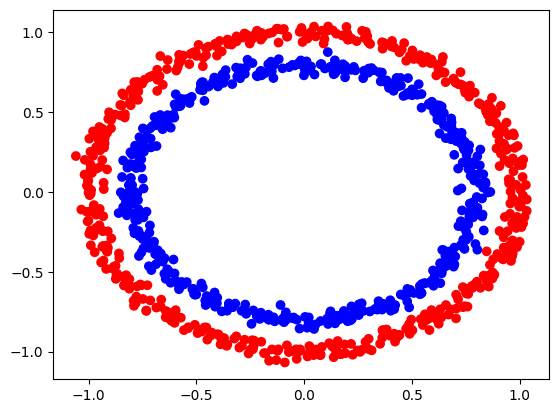

In [3]:
fig = plt.figure(figsize=(10, 10)) # 3d plotting
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0], data[1], data['target'], color=data['colors'])
plt.show()

plt.scatter(data[0], data[1], c=data['colors']) # 2d plotting
plt.show()

In [4]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [5]:
data['target'].value_counts()

target
1    500
0    500
Name: count, dtype: int64

another way to plotting data

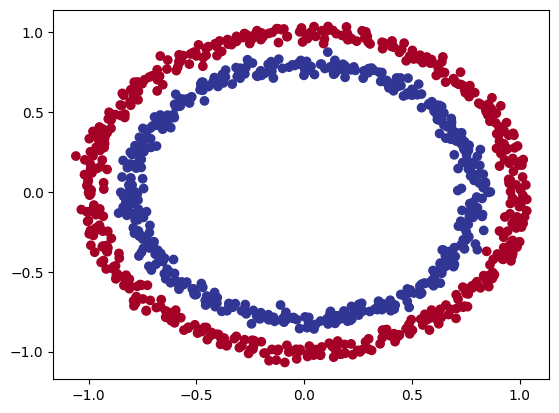

In [6]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [7]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


moving data to tensors

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.6981],
        [0.7287],
        [0.5101],
        [0.7519],
        [0.3389],
        [0.3588],
        [0.5806],
        [0.4936],
        [0.5177],
        [0.7289]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [17]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6981],
        [0.7287],
        [0.5101],
        [0.7519],
        [0.3389]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6678],
        [0.6745],
        [0.6248],
        [0.6796],
        [0.5839]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [19]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

all_test_accuracy = []
all_train_accuracy = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        all_train_accuracy.append(acc)
        all_test_accuracy.append(test_acc)

Epoch: 0 | Loss: 0.72837, Accuracy: 50.00% | Test loss: 0.73125, Test acc: 50.00%
Epoch: 10 | Loss: 0.70553, Accuracy: 50.00% | Test loss: 0.70970, Test acc: 50.00%
Epoch: 20 | Loss: 0.69797, Accuracy: 57.00% | Test loss: 0.70223, Test acc: 56.50%
Epoch: 30 | Loss: 0.69530, Accuracy: 53.87% | Test loss: 0.69938, Test acc: 51.50%
Epoch: 40 | Loss: 0.69427, Accuracy: 52.62% | Test loss: 0.69814, Test acc: 50.50%
Epoch: 50 | Loss: 0.69381, Accuracy: 51.50% | Test loss: 0.69750, Test acc: 48.50%
Epoch: 60 | Loss: 0.69358, Accuracy: 51.75% | Test loss: 0.69711, Test acc: 47.50%
Epoch: 70 | Loss: 0.69343, Accuracy: 51.25% | Test loss: 0.69682, Test acc: 49.00%
Epoch: 80 | Loss: 0.69334, Accuracy: 51.00% | Test loss: 0.69659, Test acc: 48.00%
Epoch: 90 | Loss: 0.69326, Accuracy: 51.25% | Test loss: 0.69640, Test acc: 47.00%
Epoch: 100 | Loss: 0.69321, Accuracy: 51.00% | Test loss: 0.69624, Test acc: 47.00%
Epoch: 110 | Loss: 0.69316, Accuracy: 51.12% | Test loss: 0.69610, Test acc: 45.50%
Epo

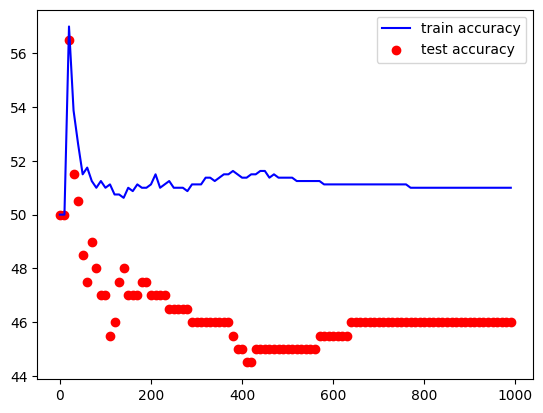

In [22]:
plt.plot(np.arange(0, 1000, 10), all_train_accuracy, c='b', label='train accuracy')
plt.scatter(np.arange(0, 1000, 10), all_test_accuracy, c='r', label='test accuracy')
plt.legend()

In [23]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


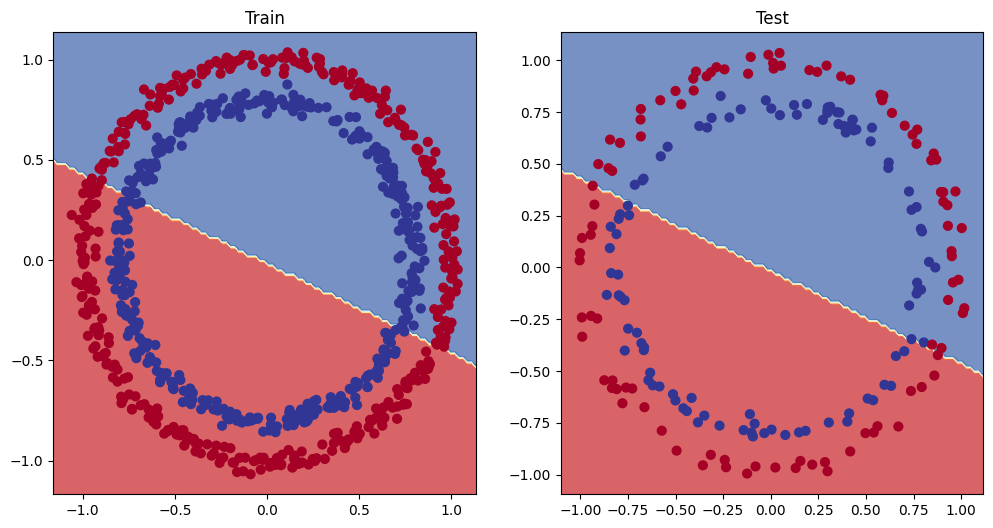

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [27]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


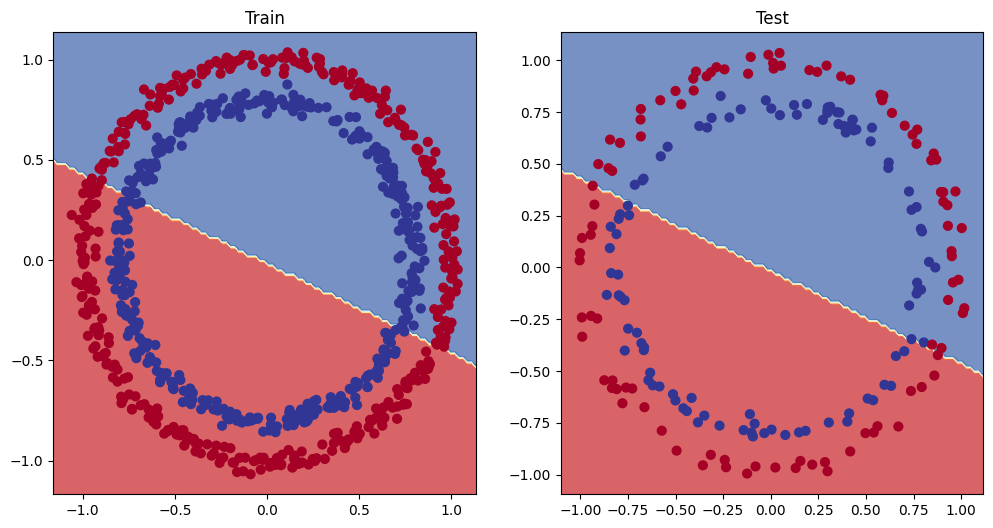

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [29]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [30]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


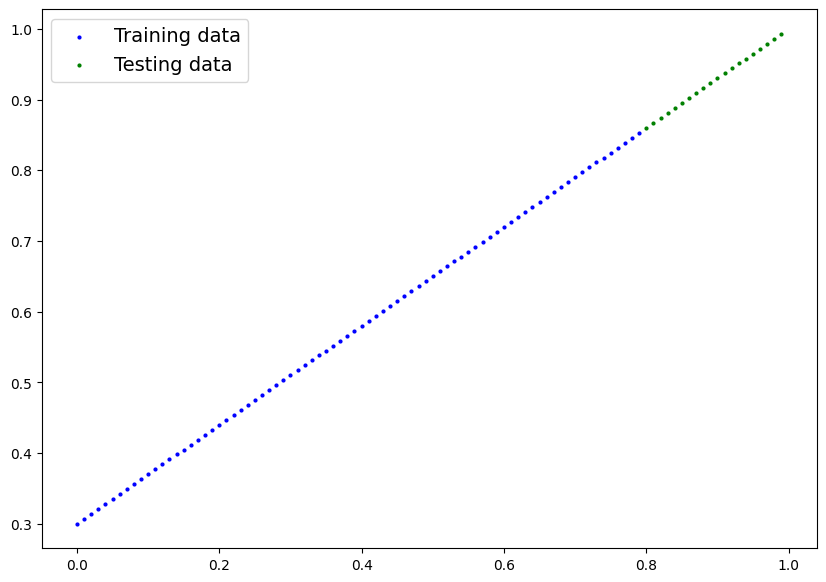

In [31]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [32]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [34]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

all_train_acc = []
all_test_acc = []
epoch_count = []

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 20 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
        all_test_acc.append(test_loss.cpu().detach().numpy())
        all_train_acc.append(loss.cpu().detach().numpy())
        epoch_count.append(epoch)

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 20 | Train loss: 0.14420, Test loss: 0.05597
Epoch: 40 | Train loss: 0.07525, Test loss: 0.00984
Epoch: 60 | Train loss: 0.10320, Test loss: 0.02754
Epoch: 80 | Train loss: 0.06937, Test loss: 0.01326
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 120 | Train loss: 0.08538, Test loss: 0.03464
Epoch: 140 | Train loss: 0.09153, Test loss: 0.02218
Epoch: 160 | Train loss: 0.06966, Test loss: 0.01357
Epoch: 180 | Train loss: 0.06925, Test loss: 0.01691
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 220 | Train loss: 0.06920, Test loss: 0.01302
Epoch: 240 | Train loss: 0.06092, Test loss: 0.00804
Epoch: 260 | Train loss: 0.07789, Test loss: 0.02168
Epoch: 280 | Train loss: 0.06780, Test loss: 0.02416
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 320 | Train loss: 0.06953, Test loss: 0.01475
Epoch: 340 | Train loss: 0.05201, Test loss: 0.00558
Epoch: 360 | Train loss: 0.05579, Test loss: 0.00743

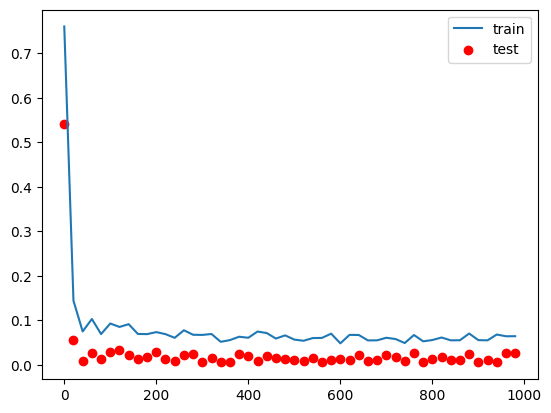

In [35]:
plt.plot(epoch_count, all_train_acc, label='train')
plt.scatter(epoch_count, all_test_acc, c='r', label='test')
plt.legend()

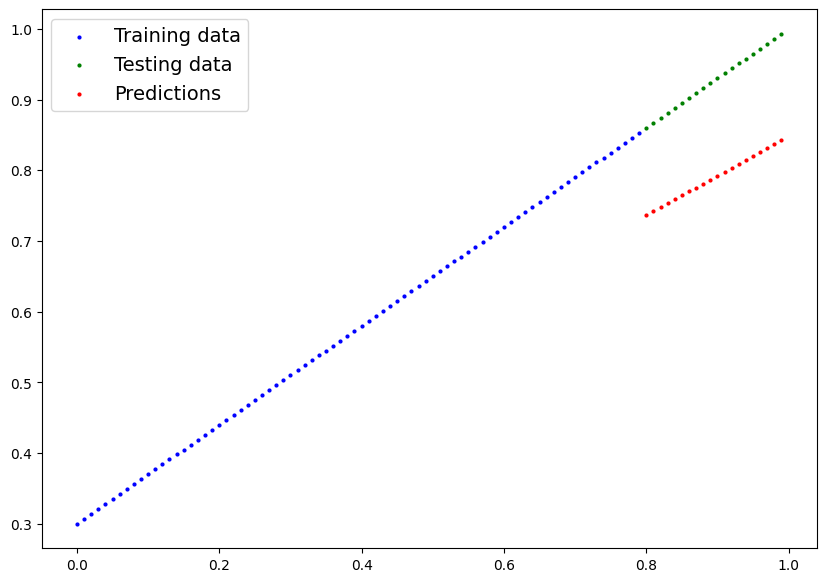

In [36]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

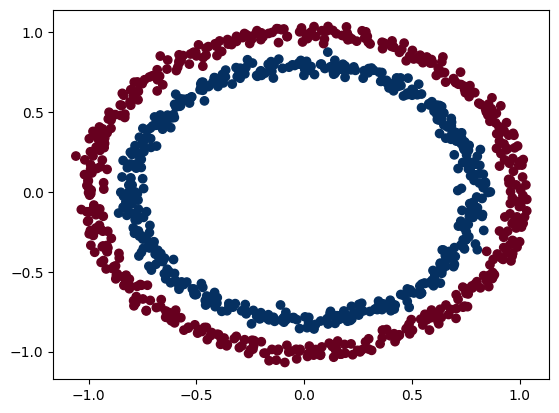

In [37]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [38]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [39]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=25)
        self.layer_3 = nn.Linear(in_features=25, out_features=15)
        self.relu = nn.PReLU() # <- add in ReLU activation function
        self.layer_4 = nn.Linear(in_features=15, out_features=1)
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.layer_2(self.relu(self.layer_1(x))))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=25, bias=True)
  (layer_3): Linear(in_features=25, out_features=15, bias=True)
  (relu): PReLU(num_parameters=1)
  (layer_4): Linear(in_features=15, out_features=1, bias=True)
)


In [40]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.1)

In [41]:
# Fit the model
torch.manual_seed(42)
epochs = 200

all_train_acc = []
all_test_acc = []
epoch_count = []

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
        all_test_acc.append(test_loss.cpu().detach().numpy())
        all_train_acc.append(loss.cpu().detach().numpy())
        epoch_count.append(epoch)

Epoch: 0 | Loss: 0.69368, Accuracy: 50.00% | Test Loss: 0.69653, Test Accuracy: 50.00%
Epoch: 5 | Loss: 0.68670, Accuracy: 50.00% | Test Loss: 0.67922, Test Accuracy: 54.50%
Epoch: 10 | Loss: 0.62257, Accuracy: 58.25% | Test Loss: 0.76083, Test Accuracy: 51.00%
Epoch: 15 | Loss: 0.60632, Accuracy: 68.25% | Test Loss: 0.58621, Test Accuracy: 72.50%
Epoch: 20 | Loss: 0.51516, Accuracy: 72.88% | Test Loss: 0.43052, Test Accuracy: 81.50%
Epoch: 25 | Loss: 0.44661, Accuracy: 73.88% | Test Loss: 0.29376, Test Accuracy: 91.00%
Epoch: 30 | Loss: 0.18552, Accuracy: 93.62% | Test Loss: 0.25677, Test Accuracy: 86.50%
Epoch: 35 | Loss: 0.06732, Accuracy: 98.75% | Test Loss: 0.18523, Test Accuracy: 92.00%
Epoch: 40 | Loss: 0.03962, Accuracy: 99.25% | Test Loss: 0.18949, Test Accuracy: 91.50%
Epoch: 45 | Loss: 0.05454, Accuracy: 98.25% | Test Loss: 0.19920, Test Accuracy: 90.00%
Epoch: 50 | Loss: 0.07519, Accuracy: 96.88% | Test Loss: 0.10299, Test Accuracy: 95.50%
Epoch: 55 | Loss: 0.09529, Accurac

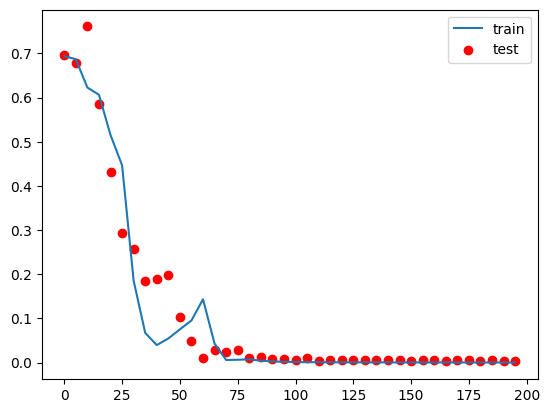

In [42]:
plt.plot(epoch_count, all_train_acc, label='train')
plt.scatter(epoch_count, all_test_acc, c='r', label='test')
plt.legend()

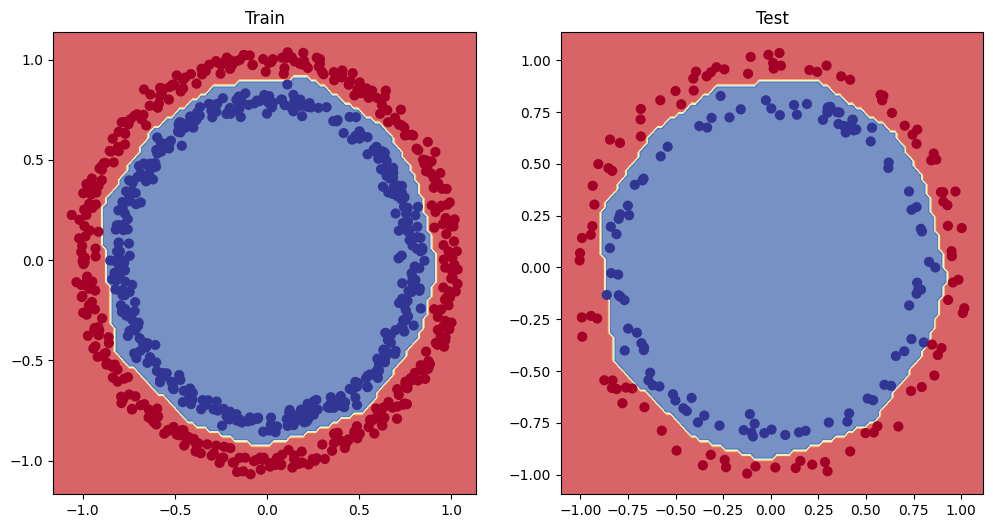

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [44]:
model_3.cuda()
X_test.device

device(type='cuda', index=0)

In [45]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

### Non-linear activation functions

In [47]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

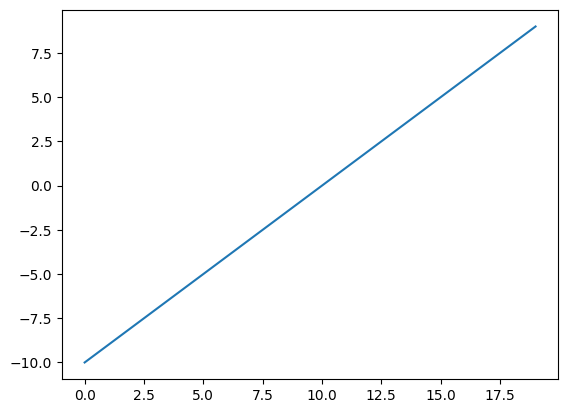

In [48]:
# Visualize the toy tensor
plt.plot(A);

In [49]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

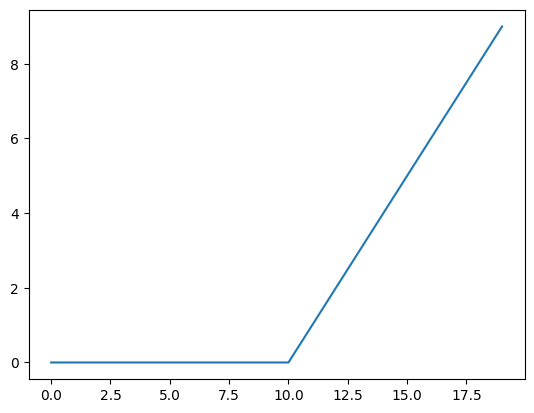

In [50]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [51]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

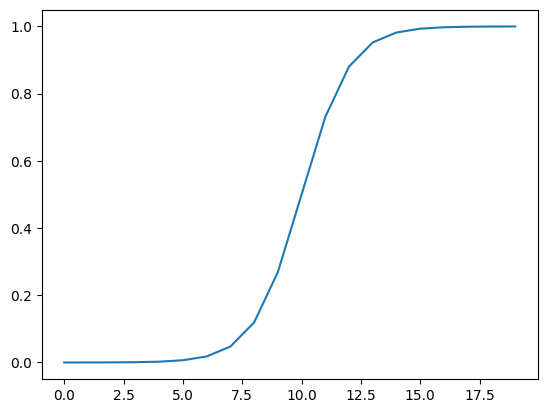

In [52]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

In [53]:
from sklearn.datasets import make_blobs

In [212]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

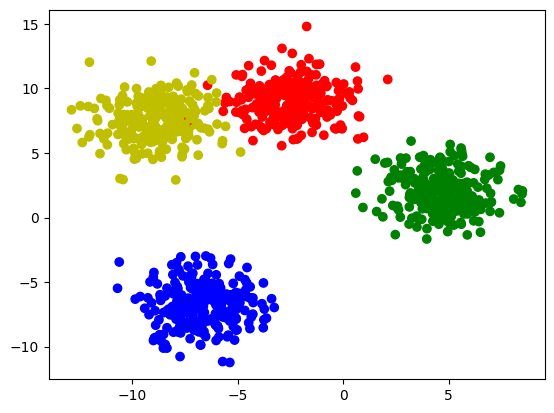

In [213]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

colors_dict = {
  0: 'r',
  1: 'g',
  2: 'b',
  3: 'y'
}
colors = pd.Series(colors_dict, name='colors')

data = pd.concat([pd.DataFrame(X_blob), pd.DataFrame(y_blob, columns=['target'])], axis=1)
data = data.join(colors, on='target')
data

plt.scatter(data[0], data[1], c=data['colors'])

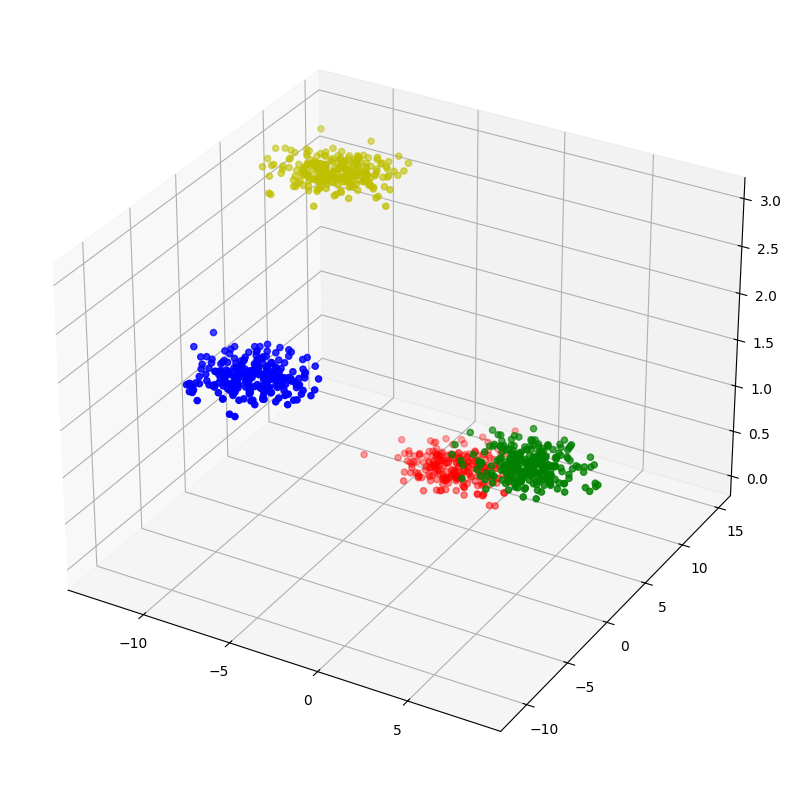

In [214]:
fig = plt.figure(figsize=(10, 10)) # 3d plotting
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0], data[1], data['target'], color=data['colors'])
plt.show()

In [215]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [216]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

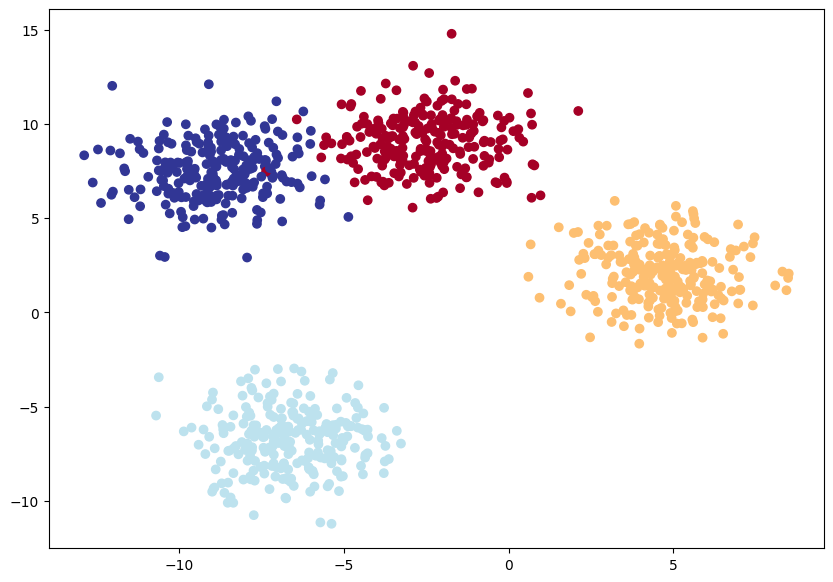

In [217]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [218]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [219]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=50),
            nn.PReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=50, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=50, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=50, out_features=4, bias=True)
  )
)

In [220]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [221]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.3492, -0.1941,  0.2474, -0.5914],
        [ 0.7691, -0.5031, -1.2615, -0.2417],
        [-0.0260,  0.1310, -0.0076, -0.1023],
        [-0.0124,  0.1600, -0.0717, -0.1243],
        [ 0.6030, -0.2593, -0.9831, -0.1475]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [222]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [223]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.3421, -0.2127,  0.1217, -0.6612],
        [ 0.4363,  0.2335, -1.0444, -0.0075],
        [-0.0260,  0.1310, -0.0076, -0.1023],
        [ 0.2513, -0.0577,  0.2673, -0.4253],
        [ 0.7074, -0.6941, -1.2522, -0.4454]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3646, 0.2093, 0.2924, 0.1337],
        [0.3724, 0.3040, 0.0847, 0.2389],
        [0.2430, 0.2843, 0.2475, 0.2252],
        [0.3069, 0.2253, 0.3118, 0.1560],
        [0.5872, 0.1446, 0.0827, 0.1854]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [224]:
# Checking total sums
print(y_pred_probs[:5].sum(dim=1))

tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SumBackward1>)


In [225]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3646, 0.2093, 0.2924, 0.1337], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [226]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

all_test_loss = []
all_train_loss = []
all_epochs = []

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        all_test_loss.append(test_loss.cpu().detach().numpy())
        all_train_loss.append(loss.cpu().detach().numpy())
        all_epochs.append(epoch)

Epoch: 0 | Loss: 1.27184, Acc: 25.12% | Test Loss: 0.87094, Test Acc: 49.00%
Epoch: 50 | Loss: 0.01752, Acc: 99.50% | Test Loss: 0.00492, Test Acc: 100.00%
Epoch: 100 | Loss: 0.01399, Acc: 99.38% | Test Loss: 0.00381, Test Acc: 100.00%
Epoch: 150 | Loss: 0.01267, Acc: 99.38% | Test Loss: 0.00290, Test Acc: 100.00%
Epoch: 200 | Loss: 0.01182, Acc: 99.38% | Test Loss: 0.00237, Test Acc: 100.00%
Epoch: 250 | Loss: 0.01120, Acc: 99.62% | Test Loss: 0.00213, Test Acc: 100.00%
Epoch: 300 | Loss: 0.01089, Acc: 99.38% | Test Loss: 0.00259, Test Acc: 100.00%
Epoch: 350 | Loss: 0.01247, Acc: 99.62% | Test Loss: 0.00269, Test Acc: 100.00%
Epoch: 400 | Loss: 0.01176, Acc: 99.38% | Test Loss: 0.00214, Test Acc: 100.00%
Epoch: 450 | Loss: 0.01085, Acc: 99.62% | Test Loss: 0.00201, Test Acc: 100.00%
Epoch: 500 | Loss: 0.01258, Acc: 99.38% | Test Loss: 0.00200, Test Acc: 100.00%
Epoch: 550 | Loss: 0.01243, Acc: 99.62% | Test Loss: 0.00391, Test Acc: 100.00%
Epoch: 600 | Loss: 0.01004, Acc: 99.62% | Te

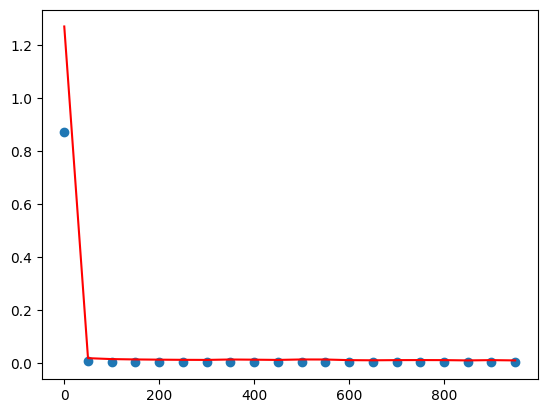

In [227]:
plt.scatter(all_epochs, all_test_loss)
plt.plot(all_epochs, all_train_loss, color='r')

In [228]:
model_4.to(device)
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  31.0094,   83.9035, -237.2870,  -87.1498],
        [  -2.5176,  -13.5523,  -34.0462,    9.7662],
        [  -5.8669,  -23.6980,   32.2138,  -37.1867],
        [  18.1356,   77.1943, -173.0143,  -68.5537],
        [  21.4080,   -7.9221, -146.5975,  -20.9002],
        [  -4.5430,  -15.2147,  -44.0533,   12.6223],
        [  -8.9972,  -22.4811,   33.9613,  -36.3910],
        [  13.3301,  -19.9145,  -93.8929,   -3.0528],
        [  -2.8154,  -28.0674,   31.1175,  -39.6506],
        [  15.5776,  -16.5492, -109.5677,   -8.0204]], device='cuda:0')

In [229]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


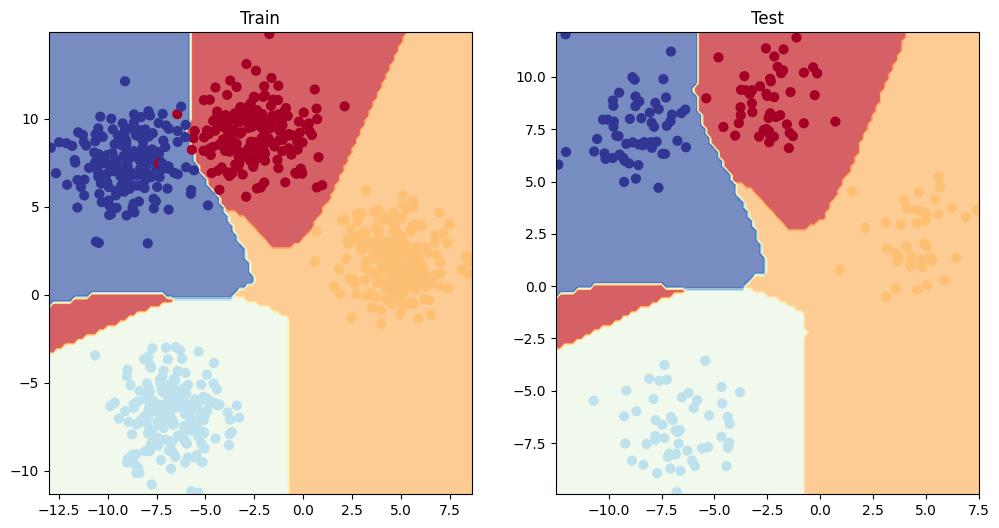

In [230]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [231]:
import torchmetrics

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(1., device='cuda:0')